In [ ]:
from IPython.display import Image
import tensorflow.keras
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import plot_model
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt

### **Keras Applications**

Ver más: https://keras.io/api/applications/

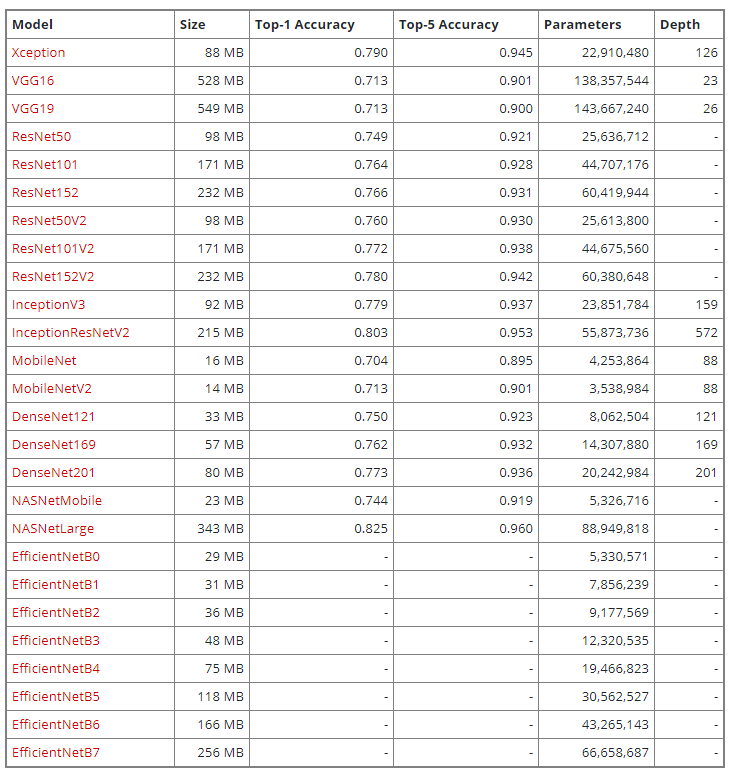

In [ ]:
#@title Cargar modelo pre-entrenado 🤖  { run: "auto" }
model_name = "ResNet50" #@param ["ResNet50"]
if model_name == "ResNet50":
  from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
  model = ResNet50(weights='imagenet')
  target_size=(224, 224)
print("Modelo cargado: {}".format(model.name))

### **Mostrar Modelo**

In [ ]:
plot_model(model)

In [ ]:
model.summary()

### **Cargar imagen de prueba 🐘🖼️**

In [ ]:
!wget -O image.jpg 'https://ichef.bbci.co.uk/news/640/cpsprodpb/14EC6/production/_124820758_pug1.jpg'
img_path = 'image.jpg'
display(Image(img_path))

In [ ]:
img = image.load_img(img_path, target_size=target_size)
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)
preds = model.predict(x)
pd.DataFrame(decode_predictions(preds, top=10)[0]).iloc[:,1:]

### **CAM con imagen de prueba 🐘🖼️**

En esta sección usamos la [implementación](https://towardsdatascience.com/class-activation-mapping-using-transfer-learning-of-resnet50-e8ca7cfd657e) de Patrick Brus de los Class Activation Maps del paper [Learning Deep Features for Discriminative Localization](https://arxiv.org/abs/1512.04150)

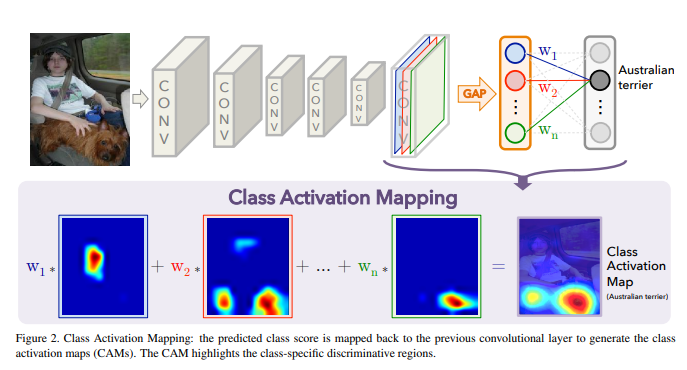

**Fuente: [Learning Deep Features for Discriminative Localization](https://arxiv.org/abs/1512.04150)**

In [ ]:
#@title get_class_activation_map()
 #Código de https://towardsdatascience.com/class-activation-mapping-using-transfer-learning-of-resnet50-e8ca7cfd657e

def get_class_activation_map(model, img):
    ''' 
    this function computes the class activation map
    
    Inputs:
        1) model (tensorflow model) : trained model
        2) img (numpy array of shape (224, 224, 3)) : input image
    '''
    
    # expand dimension to fit the image to a network accepted input size
    img = np.expand_dims(img, axis=0)

    # predict to get the winning class
    predictions = model.predict(img)
    label_index = np.argmax(predictions)

    # Get the 2048 input weights to the softmax of the winning class.
    class_weights = model.layers[-1].get_weights()[0]
    class_weights_winner = class_weights[:, label_index]
    
    # get the final conv layer
    final_conv_layer = model.get_layer("conv5_block3_out")
    
    # create a function to fetch the final conv layer output maps (should be shape (1, 7, 7, 2048)) 
    get_output = tensorflow.keras.backend.function([model.layers[0].input],[final_conv_layer.output, model.layers[-1].output])
    [conv_outputs, predictions] = get_output([img])
    
    # squeeze conv map to shape image to size (7, 7, 2048)
    conv_outputs = np.squeeze(conv_outputs)
    
    # bilinear upsampling to resize each filtered image to size of original image 
    mat_for_mult = scipy.ndimage.zoom(conv_outputs, (32, 32, 1), order=1) # dim: 224 x 224 x 2048

    # get class activation map for object class that is predicted to be in the image
    final_output = np.dot(mat_for_mult.reshape((224*224, 2048)), class_weights_winner).reshape(224,224) # dim: 224 x 224
    
    # return class activation map
    return final_output, label_index

In [ ]:
out = get_class_activation_map(model, img)
plt.imshow(img)
plt.imshow(out[0], alpha=0.5, cmap='inferno')

### **Capturar Imagen de Prueba 📷**



In [ ]:
#@title Helper - capturar webcam
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

In [ ]:
try:
  filename = take_photo()
  print('Saved to {}'.format(filename))
  display(Image(filename))
except Exception as err:
  print(str(err))

img = image.load_img(filename, target_size=target_size)
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)
preds = model.predict(x)
pd.DataFrame(decode_predictions(preds, top=10)[0]).iloc[:,1:]

In [ ]:
plt.figure(figsize=(10,10))
out = get_class_activation_map(model, img)
plt.imshow(img)
plt.imshow(out[0], alpha=0.5, cmap='inferno')
plt.show()